# Using the Deit Model from Pytorch

In a setup with limited computational resources, the Deit model is useful because it can compete with CNNs with lesser data (due to augmentation)
and computational requriements

In [1]:
!pip install torch torchvision timm pandas requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 627.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 6.6 MB/s eta 0:00:00


In [10]:
from PIL import Image
import torch
import timm
import requests
import torchvision
import torchvision.transforms as transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD #mainly for image normalization wherein X_i = ((X_i - mean)/ std)
import matplotlib.pyplot as plt

print(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)

(0.485, 0.456, 0.406) (0.229, 0.224, 0.225)


In [3]:
def show_tensor_image(tensor,title = 'None', mean = None, std_dev = None):
    mean = torch.tensor([0.5]*3) if mean is None else mean
    std = torch.tensor([0.5]*3) if std_dev is None else std_dev

    # Clone the tensor to not make changes to the original
    image = tensor.clone().detach()
    
    # Convert from Tensor image
    image = image.to(torch.device('cpu'))

    # Revert the tensor normalization
    image = transforms.Normalize(-mean / std, 1.0 / std)(image)
    
    # Change the order of dimensions from (C, H, W) to (H, W, C) for displaying
    image = image.permute(1, 2, 0)
    
    # Clip to ensure it's within valid image range
    image = torch.clamp(image, 0, 1)
    
    # Show image
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


In [4]:
print(torch.__version__)

1.8.0+cu111


Downloading: "https://github.com/facebookresearch/deit/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


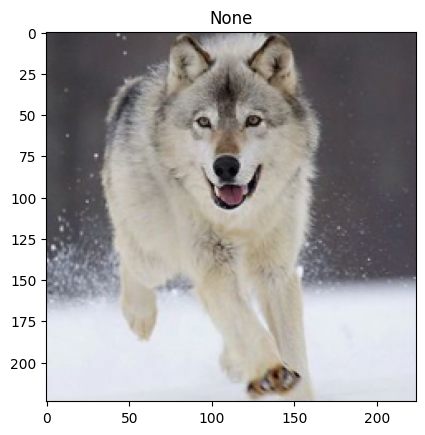

In [5]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model.eval()

transform = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

img = Image.open(requests.get("https://raw.githubusercontent.com/pytorch/ios-demo-app/master/HelloWorld/HelloWorld/HelloWorld/image.png", stream=True).raw)
img = transform(img)[None,]
img_visualization = img.clone().detach()
img_visualization = img.squeeze()
show_tensor_image(img_visualization,mean=torch.tensor(IMAGENET_DEFAULT_MEAN), std_dev=torch.tensor(IMAGENET_DEFAULT_STD))

In [6]:

out = model(img)
clsidx = torch.argmax(out)
print(clsidx.item())

269


In [7]:
clsidx.item() #corresponds to gray wolf

269

# Understanding How to Fine-Tune the Deit Model on a custom dataset 

In this case, lets start with a readily available dataset, the CIFAR-10 dataset, that can be easily loaded using torchvision's dataset 

## Let's have a look at Deit's configs 
hidden_size = 76
8num_hidden_layers = 12
num_attention_heads = 12
intermediate_size = 3072
hidden_act = 'gelu'
hidden_dropout_prob = 0.0
attention_probs_dropout_prob = 0.0
initializer_range = 0.02
layer_norm_eps = 1e-12
image_size = 224
patch_size = 16
num_channels = 3
qkv_bias = True
encoder_stride = 16**kwargs

In [8]:
# Transform the data to tensor and normalize it
transform = transforms.Compose(
    [transforms.Resize((224, 224)),  # Resize images to match DeiT input
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalization

## Downloading the training and test dataset and loading the dataset 

In [11]:
# Load the training and test sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [12]:
# Classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Modifying the number of classes for the classification head 

In [13]:
# Modify the classifier head
num_classes = 10  # CIFAR-10 has 10 classes
model.head = torch.nn.Linear(model.head.in_features, num_classes)

### Defining loss function and the optimizer

In [15]:
import torch.optim as optim
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### training the model here

In [17]:
num_epochs = 1

In [ ]:
for epoch in range(num_epochs):  # Loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # Print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')